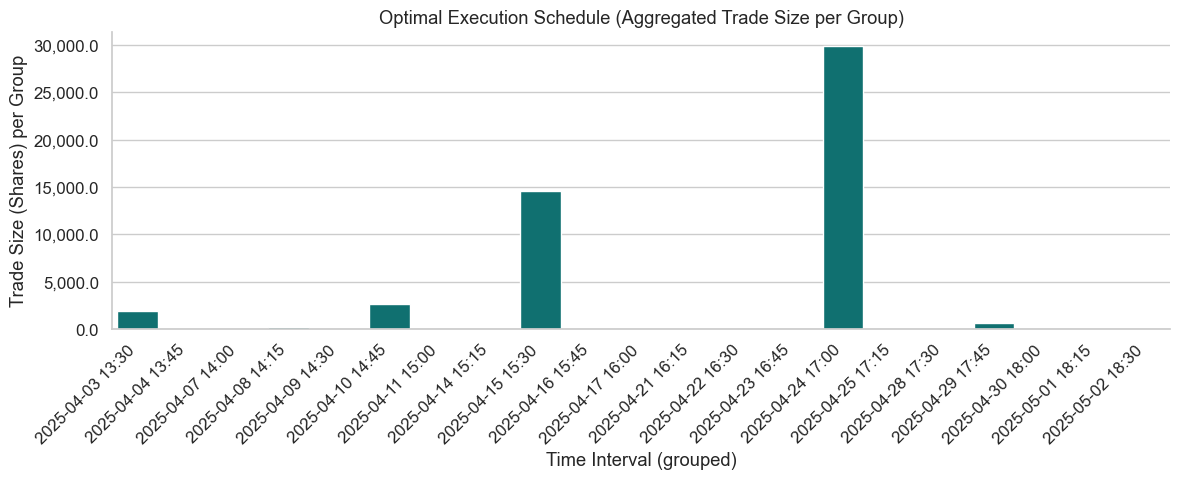

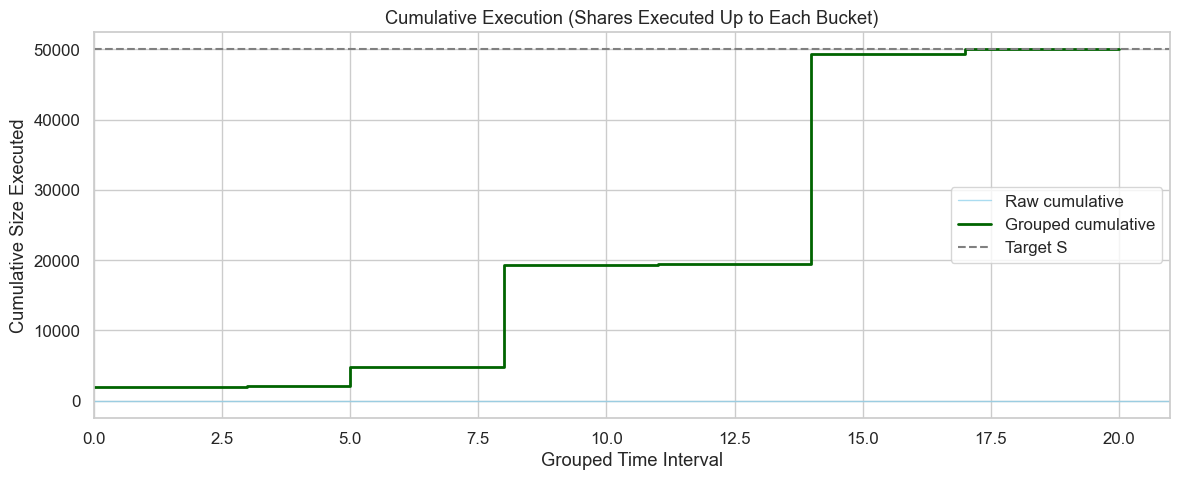

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

with open('alpha_series.pkl', 'rb') as f:
    alpha_series = pickle.load(f)

alpha_series = alpha_series.replace([np.inf, -np.inf], np.nan).dropna()
alpha_series = alpha_series[alpha_series > 0]

total_order_size = 50000
gamma_fixed = 0.5

def compute_optimal_execution(alpha_series, total_size_S, gamma=0.5):
    alpha_arr = np.array(alpha_series.values, dtype=np.float64)
    if np.any(alpha_arr <= 0):
        raise ValueError("All alpha_i values must be positive and finite.")
    k = 1.0 / (gamma - 1.0)
    weights = (gamma * alpha_arr) ** k
    weights = np.maximum(weights, 1e-12)
    total_weight = np.sum(weights)
    x = total_size_S * weights / total_weight
    x = np.maximum(x, 0)
    return pd.Series(data=x, index=alpha_series.index)

optimal_schedule = compute_optimal_execution(alpha_series, total_order_size, gamma=gamma_fixed)

# ---- 1. BAR PLOT: AGGREGATED SCHEDULE ----
sns.set(style="whitegrid", font_scale=1.1)
n_buckets = len(optimal_schedule)
n_groups = 20
group_size = max(1, n_buckets // n_groups)

grouped_sched = optimal_schedule.groupby(np.arange(n_buckets)//group_size).sum()
grouped_index = alpha_series.index[::group_size][:len(grouped_sched)]

plt.figure(figsize=(12,5))
ax = sns.barplot(x=np.arange(len(grouped_sched)), y=grouped_sched.values, color="teal")
ax.set_xticks(range(len(grouped_index)))
ax.set_xticklabels([str(i)[:16] for i in grouped_index], rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:,.1f}'.format(y)))
plt.title("Optimal Execution Schedule (Aggregated Trade Size per Group)")
plt.xlabel("Time Interval (grouped)")
plt.ylabel("Trade Size (Shares) per Group")
plt.tight_layout()
sns.despine()
plt.show()

# ---- 2. CUMULATIVE SCHEDULE PLOT: BOTH FULL & GROUPED ----
plt.figure(figsize=(12,5))
# Plot full step cumulative for raw schedule:
plt.plot(range(n_buckets), optimal_schedule.cumsum(), drawstyle='steps-post', color='skyblue', lw=1, alpha=0.7, label="Raw cumulative")
# Also plot grouped (visible) cumulative:
plt.step(np.arange(len(grouped_sched)), grouped_sched.cumsum(), where='post', color='darkgreen', lw=2, label="Grouped cumulative")
plt.axhline(total_order_size, linestyle='--', color='gray', label='Target S')
plt.title("Cumulative Execution (Shares Executed Up to Each Bucket)")
plt.xlabel("Grouped Time Interval")
plt.ylabel("Cumulative Size Executed")
plt.legend()
plt.xlim(0, len(grouped_sched))
plt.tight_layout()
plt.show()
